In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

# 1.데이터 불러오기

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/train.csv')
df_org = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Data/Machine_Signal_30_train.csv')

In [3]:
df = df_train.copy()

In [4]:
df.head(3)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,Y
0,MA1074_4-20210901-0,MA1074_4,20210901,0,17.598889,32.0,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,0.0
1,MA1074_4-20210901-1,MA1074_4,20210901,1,13.039444,25.0,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,0.0
2,MA1074_4-20210901-2,MA1074_4,20210901,2,10.153889,23.0,99.583333,99.411765,100.000000,16.333186,11.431835,101.656051,0.0


# 3.데이터 전처리

## 3.1 trainX, trainY

- 결측치 처리

In [5]:
# train = df.interpolate(method='polynomial', order=5)
df = df.fillna(method='ffill')

In [6]:
# train.fillna(method='ffill', inplace=True)
# train = train.interpolate(method='linear')

In [7]:
df['time'] = pd.to_datetime(df['date'].astype(str)+df['hour'].astype(str), format='%Y%m%d%H')

In [8]:
df.columns

Index(['ckey', 'machine_id', 'date', 'hour', 'connect_avg', 'connect_max',
       'in_handover_rate', 'out_handover_rate', 'inter_handover_rate',
       'lower_prb', 'upper_prb', 'reconfig_rate', 'Y', 'time'],
      dtype='object')

In [9]:
train = df.drop(['ckey', 'machine_id', 'Y'], axis=1)

## 3.3 datetime

In [10]:
train['year'] = train['time'].dt.year
train['month'] = train['time'].dt.month
train['day'] = train['time'].dt.day
train['hour'] = train['time'].dt.hour
train['dayofweek'] = train['time'].dt.dayofweek

## 3.3 train_test_split

In [11]:
train['sin_hour'] = np.sin(train['hour']/24*2*np.pi)
train['cos_hour'] = np.cos(train['hour']/24*2*np.pi)

train['sin_day'] = np.sin(train['day']/31*2*np.pi)
train['cos_day'] = np.cos(train['day']/31*2*np.pi)

train['sin_dayofweek'] = np.sin(train['dayofweek']/7*2*np.pi)
train['cos_dayofweek'] = np.cos(train['dayofweek']/7*2*np.pi)

In [12]:
train.sample()

,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,...,year,month,day,dayofweek,sin_hour,cos_hour,sin_day,cos_day,sin_dayofweek,cos_dayofweek
1934,20210920,14,3.647026,8.0,100.0,100.0,100.0,5.29542,3.766202,101.995565,...,2021,9,20,0,-0.5,-0.866025,-0.790776,-0.612106,0.0,1.0


In [13]:
target_column = 'upper_prb'
trainX = train.drop([target_column], axis=1)
trainY = train[target_column]

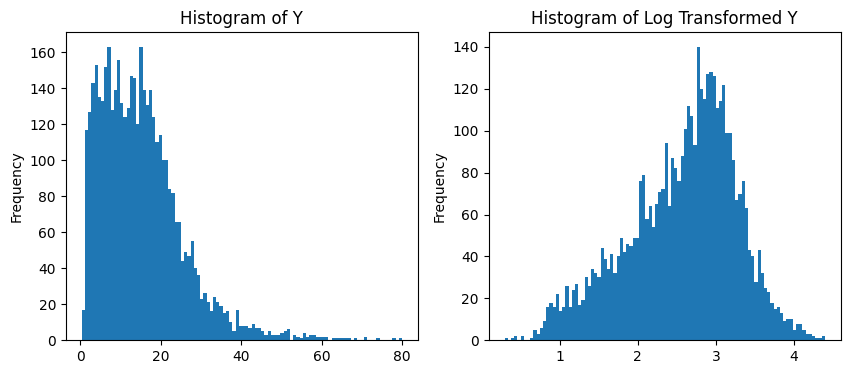

In [14]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
trainY.plot(kind='hist', bins=100, title='Histogram of Y',ax=axs[0])
np.log1p(trainY).plot(kind='hist', bins=100, title='Histogram of Log Transformed Y',ax=axs[1])
plt.show()

In [15]:
X_train = trainX[trainX['time']<'2021-10-01']
X_test = trainX[trainX['time']>='2021-10-01']

y_train = trainY[trainX['time']<'2021-10-01']
y_test = trainY[trainX['time']>='2021-10-01']

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=0)

In [17]:
# print(y_train.value_counts(normalize=True))
# print()
# print(y_test.value_counts(normalize=True))

In [18]:
categorical_columns = ['year', 'month', 'day', 'hour', 'dayofweek']
numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'lower_prb', 'inter_handover_rate', 'upper_prb', 'reconfig_rate']
numerical_columns.remove(target_column)
target_column = [target_column]

In [19]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = make_column_transformer(
    (scaler, numerical_columns),
    (ohe, categorical_columns),
    ('passthrough', ['sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'sin_dayofweek', 'cos_dayofweek']),
    ('drop', ['date', 'time'])
)

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
y_train_log = np.log1p(y_train)

# 4.모델 적용

In [20]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error

## 4.1 LR, DT, RF, XGB

In [21]:
estimators = [
    ('Linear Regression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Decision Tree', DecisionTreeRegressor(random_state=0)),
    ('Random Forest', RandomForestRegressor(random_state=0)),
    ('GBM', GradientBoostingRegressor(random_state=0)),
    ('XGBoost', XGBRegressor(random_state=0))
]

In [22]:
for name, model in estimators:
    model = model
    model.fit(X_train_processed, y_train)
    train_pred = model.predict(X_train_processed)
    test_pred = model.predict(X_test_processed)
    print('-*-'* 10)
    print(f'{name} Score')
    print('-'* 35)
    print('Train R2 Score :', r2_score(y_train, train_pred) )
    print('Train RMSE :', mean_squared_error(y_train, train_pred, squared=False ) )
    print('\nTest R2 Score :', r2_score(y_test, test_pred) )
    print('Test RMSE :', mean_squared_error(y_test, test_pred, squared=False ) )
    print()

-*--*--*--*--*--*--*--*--*--*-
Linear Regression Score
-----------------------------------
Train R2 Score : 0.6446885140247384
Train RMSE : 4.568680226175462

Test R2 Score : -3.605965138032546e+22
Test RMSE : 2265942837728.267

-*--*--*--*--*--*--*--*--*--*-
Ridge Score
-----------------------------------
Train R2 Score : 0.6446795349501491
Train RMSE : 4.568737953357073

Test R2 Score : 0.5829113763546135
Test RMSE : 7.706414424465639

-*--*--*--*--*--*--*--*--*--*-
Decision Tree Score
-----------------------------------
Train R2 Score : 1.0
Train RMSE : 0.0

Test R2 Score : 0.210381521386947
Test RMSE : 10.603441374611695

-*--*--*--*--*--*--*--*--*--*-
Random Forest Score
-----------------------------------
Train R2 Score : 0.9673092989020206
Train RMSE : 1.3857926564961858

Test R2 Score : 0.46747234218923006
Test RMSE : 8.707816574517693

-*--*--*--*--*--*--*--*--*--*-
GBM Score
-----------------------------------
Train R2 Score : 0.84266834514414
Train RMSE : 3.0401442704894253


In [23]:
for name, model in estimators:
    model = model
    model.fit(X_train_processed, y_train_log)
    train_pred = model.predict(X_train_processed)
    test_pred_log = model.predict(X_test_processed)
    test_pred = np.expm1(test_pred_log)
    y_test_log = np.log1p(y_test)
    print('-*-'* 10)
    print(f'{name} Score')
    print('-'* 35)
    print('Train R2 Score :', r2_score(y_train, train_pred) )
    print('Train RMSE :', mean_squared_error(y_train, train_pred, squared=False ) )
    print('\nTest R2 Score :', r2_score(y_test_log, test_pred_log) )
    print('Test RMSE :', mean_squared_error(y_test_log, test_pred_log, squared=False ) )
    print()

-*--*--*--*--*--*--*--*--*--*-
Linear Regression Score
-----------------------------------
Train R2 Score : -1.6258534643644351
Train RMSE : 12.419993872358317

Test R2 Score : -3.1859261755542687e+22
Test RMSE : 124791814690.70499

-*--*--*--*--*--*--*--*--*--*-
Ridge Score
-----------------------------------
Train R2 Score : -1.6261580640177975
Train RMSE : 12.420714212654357

Test R2 Score : 0.698757239805854
Test RMSE : 0.3837307082603708



<ipython-input-23-b3d0e9966332>:6: RuntimeWarning: overflow encountered in expm1
  test_pred = np.expm1(test_pred_log)


-*--*--*--*--*--*--*--*--*--*-
Decision Tree Score
-----------------------------------
Train R2 Score : -1.5868973727860909
Train RMSE : 12.327520633897743

Test R2 Score : 0.5100333237849178
Test RMSE : 0.4893859737748413

-*--*--*--*--*--*--*--*--*--*-
Random Forest Score
-----------------------------------
Train R2 Score : -1.5966485806947466
Train RMSE : 12.3507328322105

Test R2 Score : 0.6539165136195542
Test RMSE : 0.4112999764813783

-*--*--*--*--*--*--*--*--*--*-
GBM Score
-----------------------------------
Train R2 Score : -1.6131820642107253
Train RMSE : 12.389990477882115

Test R2 Score : 0.6632065103225274
Test RMSE : 0.40574211625209444

-*--*--*--*--*--*--*--*--*--*-
XGBoost Score
-----------------------------------
Train R2 Score : -1.5903128887878193
Train RMSE : 12.335656046553908

Test R2 Score : 0.6892500772122927
Test RMSE : 0.3897389051613864



## 4.2 결과 확인

In [24]:
rf = RandomForestRegressor()
rf.fit(X_train_processed, y_train)

RandomForestRegressor()

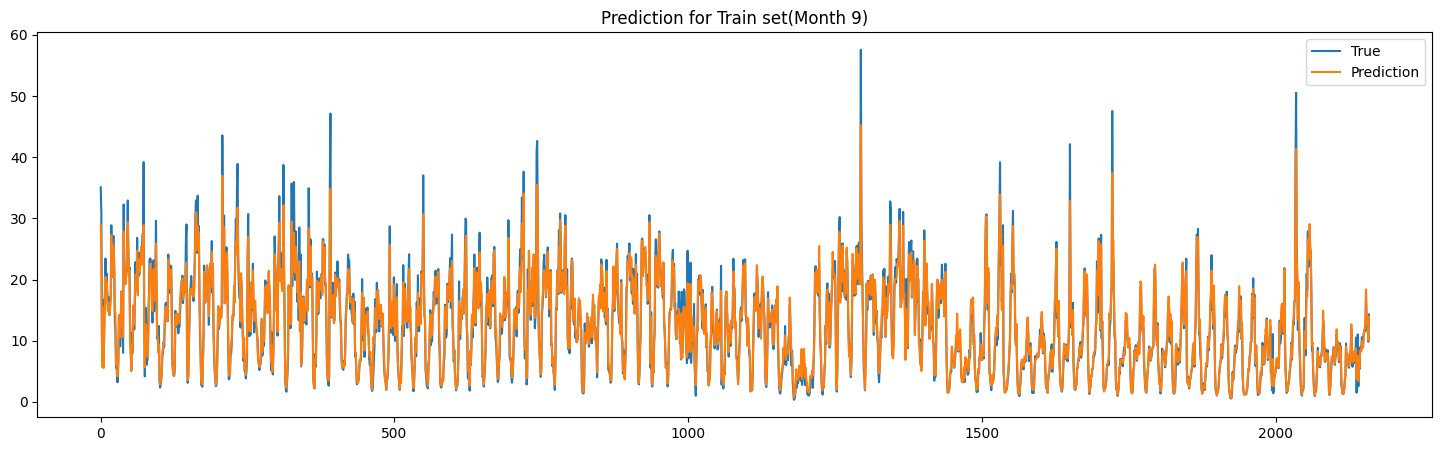

In [25]:
train_pred = rf.predict(X_train_processed)
len(y_train), len(train_pred)

plt.figure(figsize=(18,5))
plt.title('Prediction for Train set(Month 9)')
plt.plot(range(len(y_train)), y_train, label='True')
plt.plot(range(len(train_pred)), train_pred, ls='-', label='Prediction')
plt.legend()
plt.show()

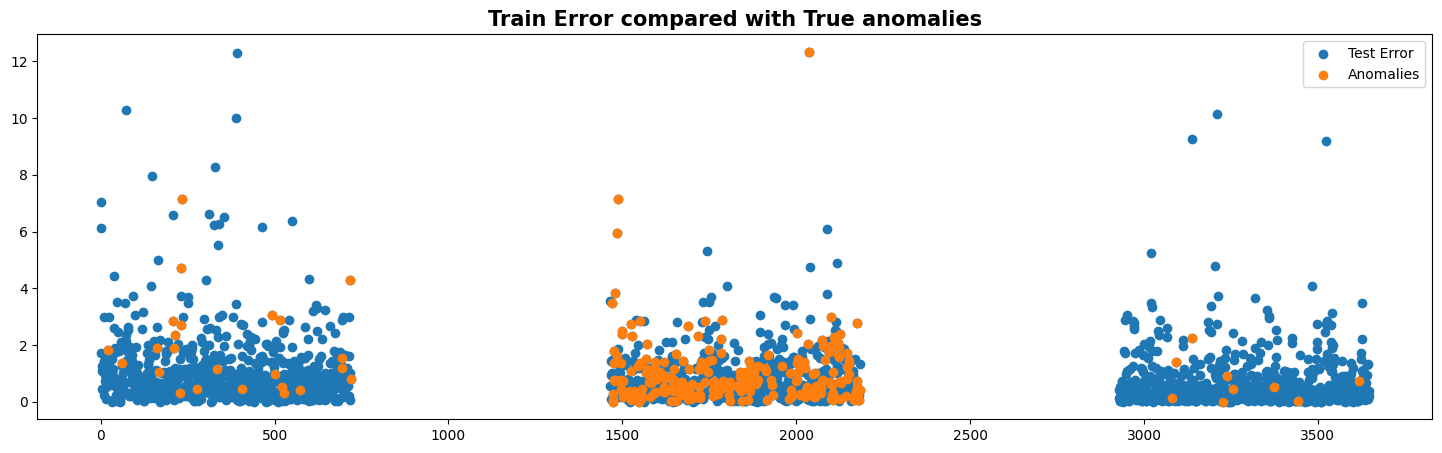

In [26]:
train_error = np.abs(y_train - train_pred)

anomalies_10 = df[df['time']<'2021-10-01']
anomalies_10_index = anomalies_10[anomalies_10['Y'] == 1.0].index
train_error[anomalies_10_index]

plt.figure(figsize=(18,5))
plt.scatter(x=train_error.index, y=train_error, label='Test Error')
plt.scatter(x=train_error[anomalies_10_index].index, y=train_error[anomalies_10_index], label='Anomalies')

plt.title('Train Error compared with True anomalies', fontsize=15, fontweight='semibold')
plt.legend()
plt.show()

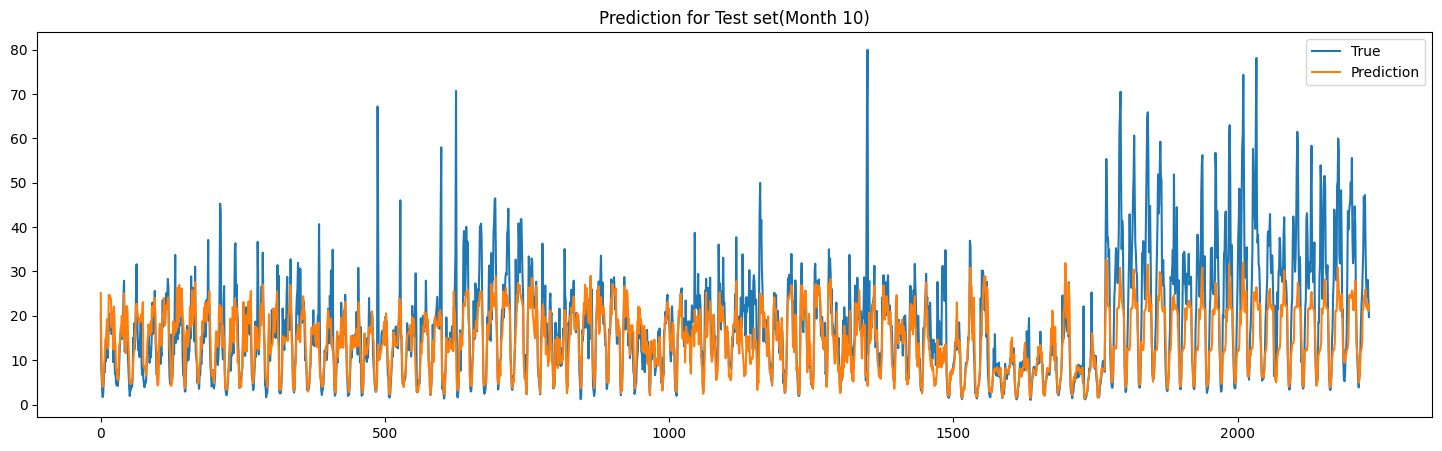

In [27]:
test_pred = rf.predict(X_test_processed)
len(y_test), len(test_pred)

plt.figure(figsize=(18,5))
plt.title('Prediction for Test set(Month 10)')
plt.plot(range(len(y_test)), y_test, label='True')
plt.plot(range(len(test_pred)), test_pred, ls='-', label='Prediction')
plt.legend()
plt.show()

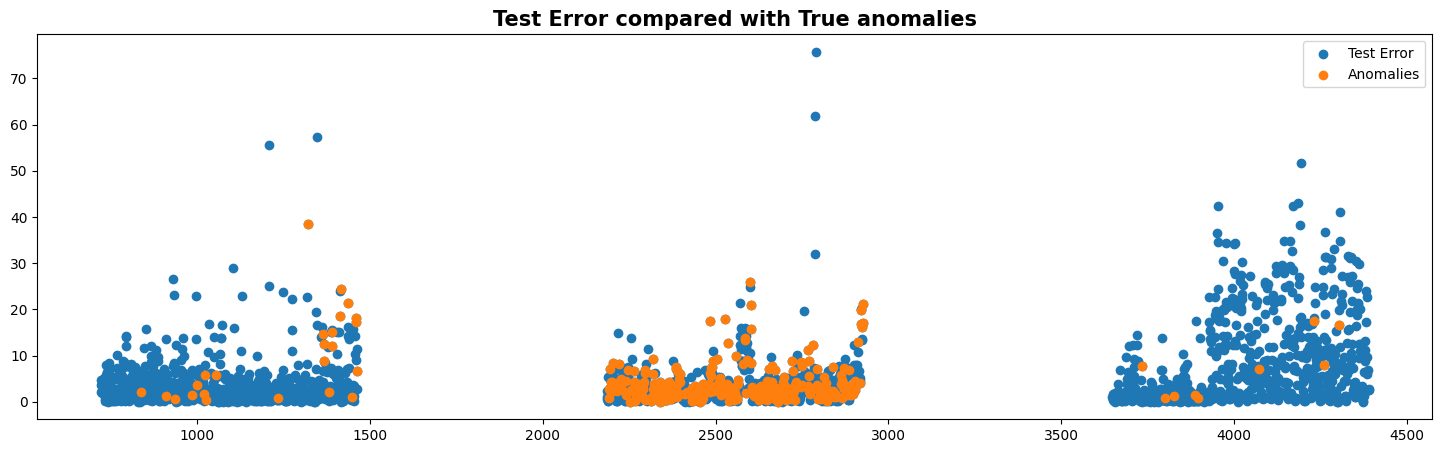

In [28]:
test_error = np.abs(y_test - test_pred)

anomalies_10 = df[df['time']>='2021-10-01']
anomalies_10_index = anomalies_10[anomalies_10['Y'] == 1.0].index
test_error[anomalies_10_index]

plt.figure(figsize=(18,5))
plt.scatter(x=test_error.index, y=test_error, label='Test Error')
plt.scatter(x=test_error[anomalies_10_index].index, y=test_error[anomalies_10_index], label='Anomalies')

plt.title('Test Error compared with True anomalies', fontsize=15, fontweight='semibold')
plt.legend()
plt.show()

In [29]:
X_train['train_error'] = train_error

<ipython-input-29-72d3e4216d20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['train_error'] = train_error


In [30]:
X_train.sort_values(by='train_error', ascending=False)[:10]

,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,reconfig_rate,time,...,month,day,dayofweek,sin_hour,cos_hour,sin_day,cos_day,sin_dayofweek,cos_dayofweek,train_error
2038,20210924,22,8.090050,13.0,92.063492,100.000000,100.000000,46.946714,100.160256,2021-09-24 22:00:00,...,9,24,4,-0.500000,8.660254e-01,-0.988468,0.151428,-0.433884,-0.900969,12.339633
391,20210917,7,16.640000,47.0,99.397590,100.000000,99.698795,24.593912,109.514260,2021-09-17 07:00:00,...,9,17,4,0.965926,-2.588190e-01,-0.299363,-0.954139,-0.433884,-0.900969,12.306375
73,20210904,1,12.580556,25.0,100.000000,100.000000,100.000000,20.637741,104.589510,2021-09-04 01:00:00,...,9,4,5,0.258819,9.659258e-01,0.724793,0.688967,-0.974928,-0.222521,10.283489
3210,20210912,18,29.945556,53.0,98.352839,99.863076,100.000000,69.793300,94.005376,2021-09-12 18:00:00,...,9,12,6,-1.000000,-1.836970e-16,0.651372,-0.758758,-0.781831,0.623490,10.158967
390,20210917,6,15.182778,34.0,95.981630,100.000000,99.537037,18.389716,116.383523,2021-09-17 06:00:00,...,9,17,4,1.000000,6.123234e-17,-0.299363,-0.954139,-0.433884,-0.900969,9.993609
3138,20210909,18,29.240556,55.0,98.434880,99.876543,99.056604,47.155206,96.621881,2021-09-09 18:00:00,...,9,9,3,-1.000000,-1.836970e-16,0.968077,-0.250653,0.433884,-0.900969,9.250537
3523,20210925,19,24.718333,40.0,98.944844,99.849170,100.000000,68.465306,93.314280,2021-09-25 19:00:00,...,9,25,5,-0.965926,2.588190e-01,-0.937752,0.347305,-0.974928,-0.222521,9.193299
329,20210914,17,19.517222,36.0,98.545455,100.000000,99.641577,21.527429,99.391629,2021-09-14 17:00:00,...,9,14,1,-0.965926,-2.588190e-01,0.299363,-0.954139,0.781831,0.623490,8.266716
146,20210907,2,9.795556,19.0,100.000000,100.000000,98.165138,18.693570,101.728568,2021-09-07 02:00:00,...,9,7,1,0.500000,8.660254e-01,0.988468,0.151428,0.781831,0.623490,7.961260
1487,20210901,23,10.000556,16.0,94.736842,100.000000,100.000000,20.954267,100.424178,2021-09-01 23:00:00,...,9,1,2,-0.258819,9.659258e-01,0.201299,0.979530,0.974928,-0.222521,7.148478


# 5.고민해야할 부분

- 일반적인 회귀 문제를 적용하는 것은 anomaly를 탐지하는데 적절하지는 않은 것으로 보임
- 위 경우 9월을 train set 10월을 test set으로 분리하여 regression 모델을 적용하였음
- 9월 학습 결과를 10월에 적용하였을 때 3번째 기지국의 경우, 타겟 범위가 최대 60까지 밖에 학습이 되어 있지 않아 10월에 대한 예측 또한 60까지밖에 하지 못함
- 실제 정답 레이블은 120까지 범위가 넘어가면서 실제와 예측 사이의 오차가 굉장히 커짐
- 또한, 예측과 실제값 사이의 오차가 클수록 이상치라고 판단하기에는 실제 anomaly 클래스를 비교해보았을 때, 합리적인 패턴이 보이지 않음

In [31]:
pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.4 MB/s eta 0:00:00


In [32]:
xgb = XGBRegressor()
xgb.fit(X_train_processed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

[01:16:44] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


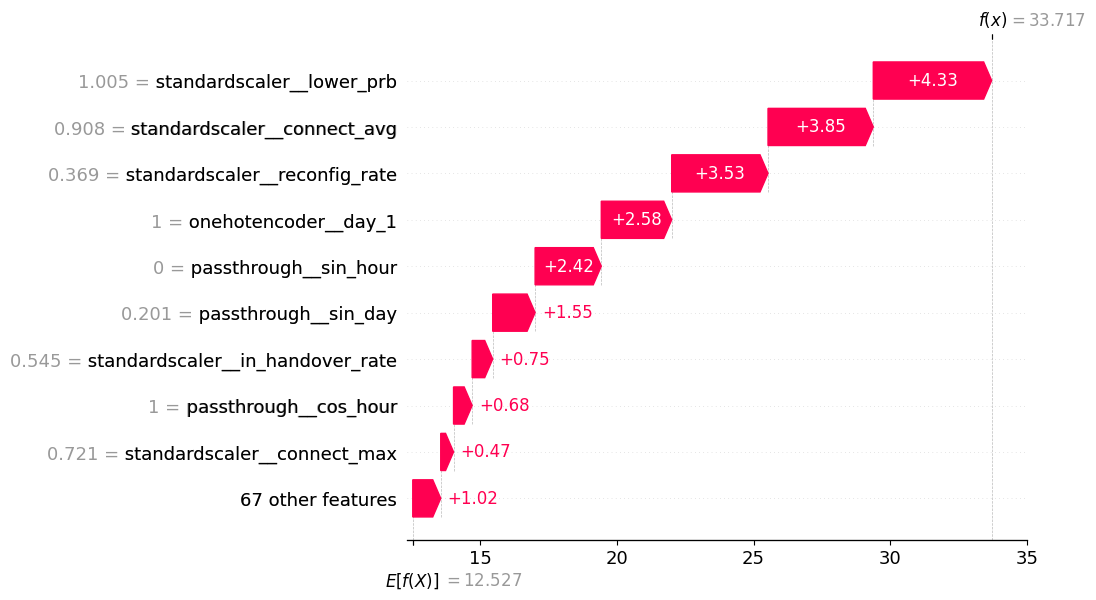

In [33]:
import shap
explainer = shap.Explainer(xgb,feature_names = preprocessor.get_feature_names_out())
shap_values=explainer(X_train_processed)
shap.plots.waterfall(shap_values[0])

## 5.1 RNN 모델 적용

In [34]:
1/0

ZeroDivisionError: ignored

In [ ]:
!pip install -q tensorflow

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

In [ ]:
df = df_org.copy()

In [ ]:
df['time'] = pd.to_datetime(df['date'].astype(str) + df['hour'].astype(str), format='%Y%m%d%H')

In [ ]:
df.machine_id.unique()

In [ ]:
target_list = ['time', 'connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']

In [ ]:
df_MA1074_4 = df.loc[df['machine_id']=='MA1074_4',:][target_list].set_index('time')
df_MA1084_11 = df.loc[df['machine_id']=='MA1084_11',:][target_list].set_index('time')
df_MA1116_1 = df.loc[df['machine_id']=='MA1116_1',:][target_list].set_index('time')

In [ ]:
train = df_MA1084_11.loc[(df_MA1084_11.index < '2021-10-01'),:]
test = df_MA1084_11.loc[~(df_MA1084_11.index < '2021-10-01'),:]

In [ ]:
train.head()

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(train)
train_scaled = scaler.transform(train)

In [ ]:
# def multivariate_data(dataset, target, start_index, end_index, history_size,
#                       target_size, step, single_step=False):
#     data = []
#     labels = []

#     start_index = start_index + history_size
#     if end_index is None:
#         end_index = len(dataset) - target_size

#     for i in range(start_index, end_index):
#         indices = range(i-history_size, i, step)
#         data.append(dataset[indices])

#         if single_step:
#             labels.append(target[i+target_size])
#         else:
#             labels.append(target[i:i+target_size])

#     return np.array(data), np.array(labels)

In [ ]:
trainX = []
trainY = []

In [ ]:
n_future = 1
n_past = 24

In [ ]:
train_scaled.shape

In [ ]:
train_scaled = pd.DataFrame(train_scaled, columns = scaler.get_feature_names_out())

In [ ]:
train_scaled

In [ ]:
for i in range(n_past, len(train_scaled) - n_future + 1):
    trainX.append(train_scaled.loc[i - n_past:i, ['connect_avg', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate']])
    trainY.append(train_scaled.loc[i + n_future - 1:i + n_future, 'connect_max' ])

In [ ]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [ ]:
print('trainX shape == {}'.format(trainX.shape))
print('trainY shape == {}'.format(trainY.shape))

In [ ]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

In [ ]:
model.predict(trainX[0].reshape(24,1))

In [ ]:
train_pred

In [ ]:
test

In [ ]:
y_pred_future=scaler.inverse_transform(prediction_copies)[:,0]

In [ ]:
predict_period_dates

In [ ]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-5-1']

sns.lineplot(data = original, x='Date', y='Open')
sns.lineplot(data = df_forecast, x='Date', y='Open')

# 6.Time Series Imputation
출처 : [시계열 데이터 전처리](https://velog.io/@leeebs/%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%A0%84%EC%B2%98%EB%A6%AC)
- 시계열에서의 결측치 처리
    - 대부분의 시계열은 비정상 데이터로 시간에 따라 평균과 분산이 변함
    - 이를 고려한 결측치 처리 방식이 필요
- imputation :
- 불완전한 데이터가 있을 때 표준이나 대표성이 있는 다른 데이터를 활용하여 대체될 수 있는 값들로 계산하여 입력하는 과정
    - 일반적인 imputation
        - mean/median
        - frequent value
        - ML Imputation
    - 시계열의 단순한 imputation
        - Last observation carried forward(LOCF) : 직전 관측치 값으로 결측치 대체
        - Next observation carried backward(NOCB) : 직후 관측치 값으로 결측치 대체
        - Moving Average/Median : 직전 N의 time window의 평균치/중앙값으로 결측치 대체
- interpolation :
    - 통계적으로 이미 구해진 데이터들로부터 주어진 데이터를 만족하는 근사 함수를 구하는 방법론
        - 선형 보간 : 근사 함수로 선형 함수 가정
        - 비선형 보간 : 근사 함수로 비선형 함수 가정
        - 스플라인(spline) 보간 : 전체 구간을 전체 구간이 아닌 소구간을 나누어 보간

- Noise :
    - 잡음을 뜻하며 데이터에서 노이즈란 다른 외부 요인의 간섭과 같은 여러 가지 의도하지 않은 데이터의 왜곡을 불러오는 모든 것을 의미
    - Moving Average :
    - Filtering :  
        - 1) 가우시안 필터링(Gaussian Filtering)
            - 노이즈가 정규분포를 따른다고 가정함(일반적으로 노이즈는 정규분포를 따름)
        - 2) 쌍방 필터(Bilateral Filter)
            - 변곡점이 큰 지점을 뭉개버린다는 특징을 갖는 가우시안 필터링의 단점을 보완
            - 데이터의 원 분포에 따라 발생하는 엣지(edge)들을 더 잘 보존할 수 있음
        - 3) 칼만 필터(Kalman Filter)
            - 현재 상태의 결합분포를 추정하는 모델링 알고리즘으로 잡음이 포함된 과거 측정값에서 현재 상태의 결합분포를 추정하는 알고리즘
            - 일반화된 분포를 가정하는 것이 아닌 데이터의 특성에 맞는 분포를 모델링할 수 있어 상당히 많이 사용되는 알고리즘

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
df = df_org.copy()

In [ ]:
df.machine_id.unique()

In [ ]:
df.loc[df['machine_id']=='MA1084_11',:].isna().sum()

In [ ]:
df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:]

In [ ]:
df.loc[df['machine_id']=='MA1084_11',"upper_prb"].plot(kind='line', figsize=(18,5))
for x in df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:].index:
    plt.axvline(x=x, color='red', ls='--')
plt.xlim((2400, 3000))
plt.show()

In [ ]:
tmp = df.loc[df['machine_id']=='MA1084_11',"upper_prb"]
tmp_inp = df.loc[df['machine_id']=='MA1084_11',"upper_prb"].interpolate(method='linear')
fig,axs = plt.subplots(5, figsize=(10,10))
for idx, time_idx in enumerate(df.loc[(df['machine_id']=='MA1084_11')&(df['upper_prb'].isna()),:].index):
    start_time = time_idx - 10
    end_time = time_idx + 10
    start = time_idx - 1
    end = time_idx + 1
    axs[idx].axvline(x=time_idx, color='red', ls='--')
    axs[idx].plot(tmp.loc[start_time:end_time], color='steelblue')
    axs[idx].plot(tmp_inp.loc[start:end], color='orange', ls='--')

plt.show()